<a href="https://colab.research.google.com/github/kleenman/tds_capstone/blob/pedro/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from fastai.vision.all import *

In [10]:
dataset_path = '/content/gdrive/MyDrive/Capstone/Data/munich_data'

# define mask function

def mask_function(name):
  img_name = str(name).split('/')[-1]
  mask_path = dataset_path + '/masks/' + img_name.replace('.jpg', '.npy')
  return np.load(mask_path)


In [11]:
# Create datablock
parks_block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ['background','park'])),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=mask_function,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=256, max_lighting=0.3)
)

# Dataloaders with batch size 4
dls4 = parks_block.dataloaders(dataset_path, bs=4)

# Dataloaders with batch size 16
dls16 = parks_block.dataloaders(dataset_path, bs=16)

# Dataloaders with batch size 32
dls32 = parks_block.dataloaders(dataset_path, bs=32)

# Dataloaders with batch size 128
dls128 = parks_block.dataloaders(dataset_path, bs=128)

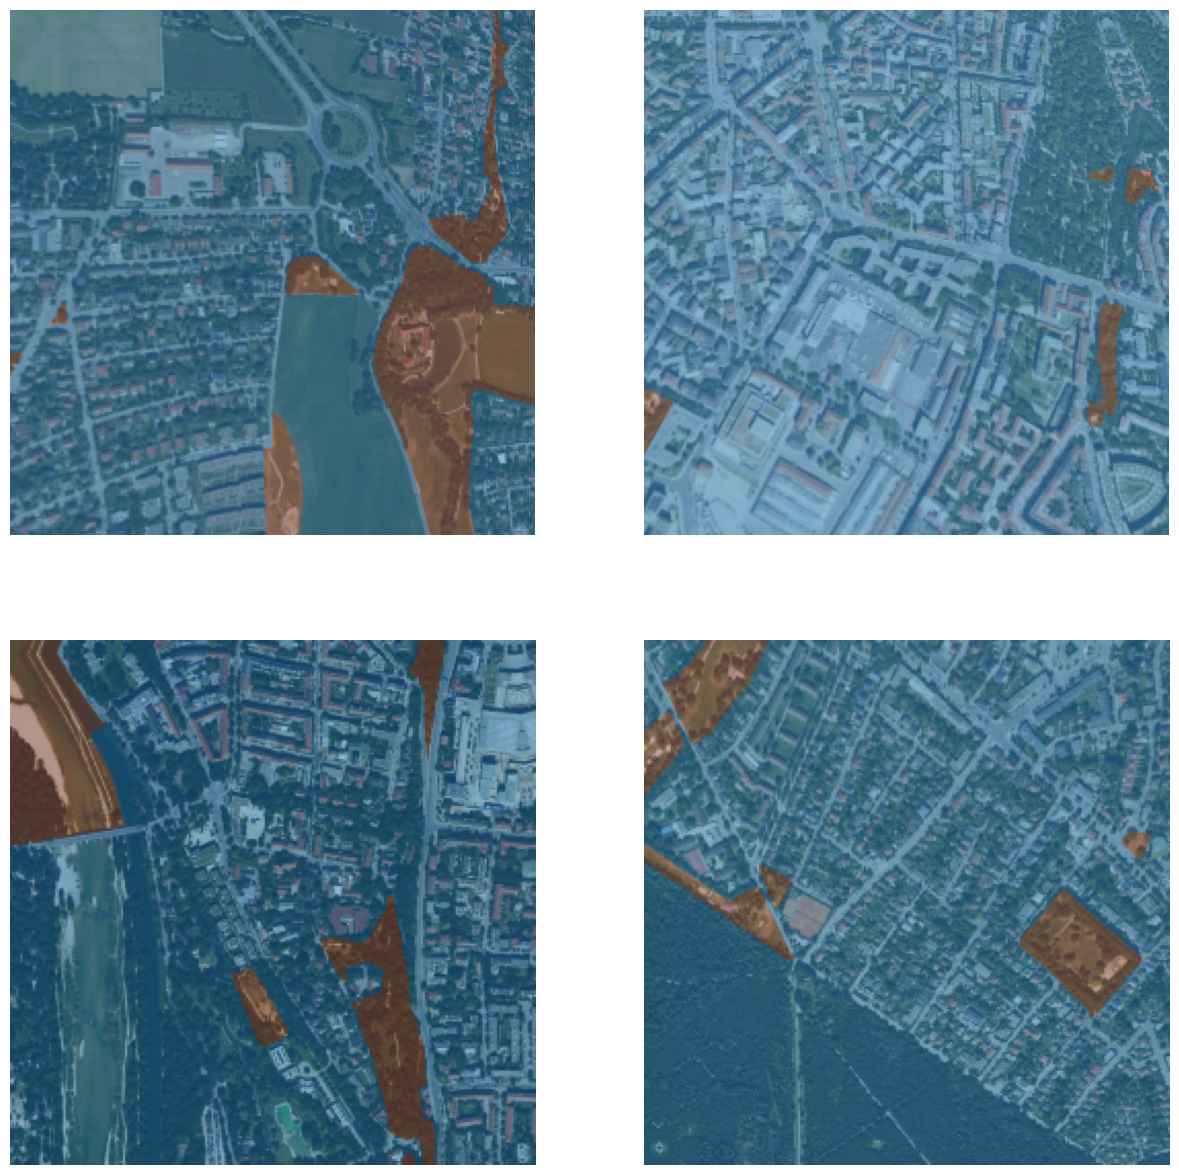

In [12]:
dls16.show_batch(figsize=(15, 15), max_n=4)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 75.3MB/s]


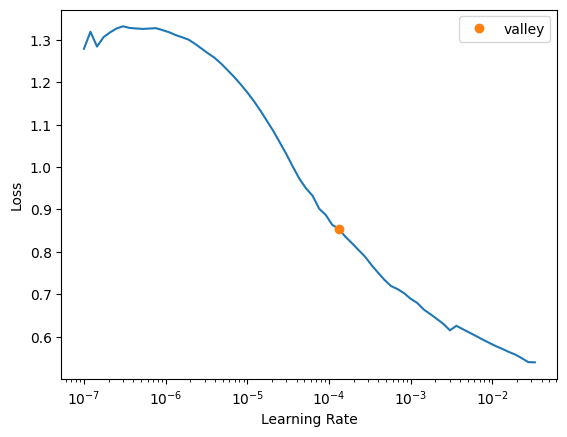

In [13]:
# Create a U-Net model with batch size 16
learn16 = unet_learner(dls16, resnet34, metrics=Dice)
lr16 = learn16.lr_find()


In [14]:
learn16.fit_one_cycle(40, lr_max=lr16.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_16')])

epoch,train_loss,valid_loss,dice,time
0,0.830821,0.476648,0.040363,00:36
1,0.562097,0.355609,0.000555,00:20
2,0.444135,0.274198,0.000239,00:19
3,0.378234,0.252195,0.000072,00:20
4,0.334855,0.244095,0.000072,00:19
5,0.303895,0.217659,0.000039,00:20
6,0.279103,0.217907,0.001158,00:19
7,0.259692,0.210825,0.292236,00:21
8,0.245491,0.253864,0.000368,00:21
9,0.231736,0.191581,0.290603,00:19


Better model found at epoch 0 with dice value: 0.04036287399337735.
Better model found at epoch 7 with dice value: 0.29223611514975284.
Better model found at epoch 10 with dice value: 0.4678459257350687.
Better model found at epoch 17 with dice value: 0.5005061875764948.
Better model found at epoch 22 with dice value: 0.5161751280117493.
No improvement since epoch 22: early stopping


In [19]:
def create_and_train_learner(dl, arch=resnet34, metrics=Dice, monitor='dice', epcohs=40, fname='model', act_cls=torch.nn.modules.activation.ReLU):
  learn = unet_learner(dl, arch, metrics=metrics, act_cls=act_cls)
  lr = learn.lr_find()
  learn.fit_one_cycle(40, lr_max=lr.valley, cbs=[
      EarlyStoppingCallback(monitor=monitor,
                            min_delta=0.01,
                            patience=10,
                            comp=np.greater),
      SaveModelCallback(monitor=monitor,
                        min_delta=0.01,
                        comp=np.greater,
                        fname=fname)])
  return learn

In [ ]:
learn4 = create_and_train_learner(dls4, fname='best_frozen_4')

epoch,train_loss,valid_loss,dice,time
0,0.789800,0.566564,0.063918,00:22
1,0.605718,0.318683,0.018585,00:22
2,0.495585,0.302781,0.005508,00:21
3,0.427427,0.284460,0.001875,00:22
4,0.386574,0.253567,0.000262,00:22
5,0.354851,0.245784,0.000039,00:21
6,0.332601,0.240487,0.000039,00:22
7,0.314959,0.264734,0.000056,00:22
8,0.302870,0.241449,0.000028,00:21
9,0.289217,0.223566,0.000022,00:22


Better model found at epoch 0 with dice value: 0.06391769698792342.
No improvement since epoch 0: early stopping


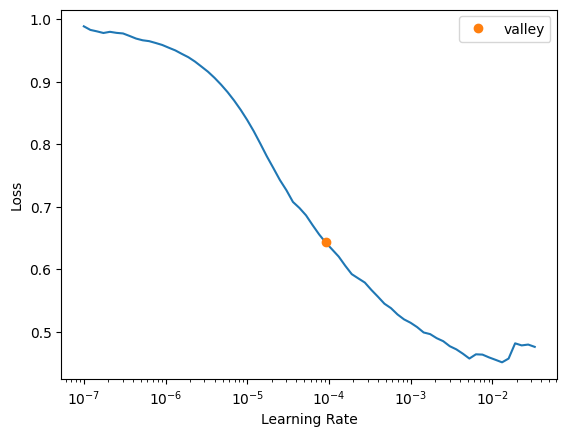

In [20]:
learn32 = create_and_train_learner(dls32, fname='best_frozen_32')

In [ ]:
learn128 = create_and_train_learner(dls128, fname='best_frozen_128')

In the next sections we will experiment with different activation functions (ELU, LeakyReLU, GELU) with the U-Net architecture and resnet34 model, while keeping all transformations and batch size constant.


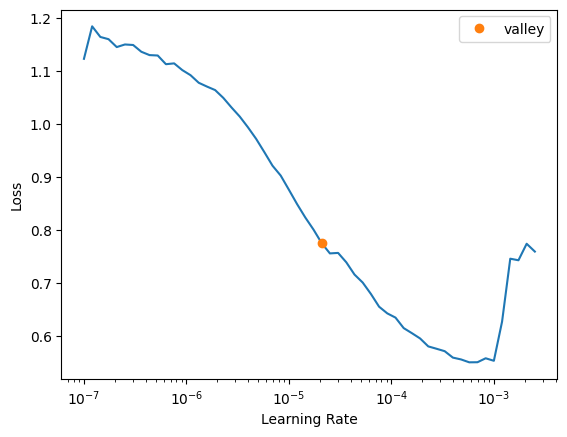

In [ ]:
# Exponential Linear Unit (ELU) activation function:

learn_ELU = create_and_train_learner(dls16, fname='best_frozen_ELU', act_cls=torch.nn.modules.activation.ELU)

The ELU activation function drastically accelerated the learning process of the model. A dice score of over 0.5 was reached as soon as epoch 19 of training, as opposed to the previous model, which used the Rectified Linear Unit activation function, and reached a comparable dice score only after unfreezing its last layers.

In [ ]:
learn_ELU = learn_ELU.load("best_frozen_ELU")
print("in-sample performance: {}".format(np.array(learn_ELU.validate(ds_idx=0)[1])))

in-sample performance: 0.6061484367936777


In [ ]:
print("our-of-sample performance: {}".format(np.array(learn_ELU.validate(ds_idx=1)[1])))

our-of-sample performance: 0.4832319307748004


The ELU activation function provided slightly better performance than RELU.
Next, we will try the LeakyRELU activation function.

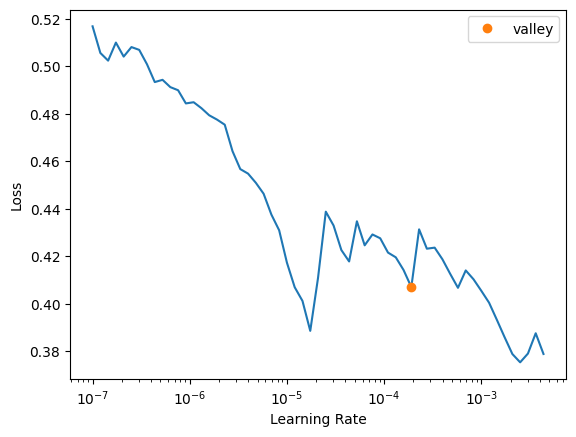

In [ ]:
learn_leaky = create_and_train_learner(dls16, fname='best_frozen_leaky', act_cls=torch.nn.modules.activation.LeakyReLU)

In [ ]:
learn_leaky = learn_leaky.load("best_frozen_leaky")
print("in-sample performance: {}".format(np.array(learn_leaky.validate(ds_idx=0)[1])))

in-sample performance: 0.6656679598129911


In [ ]:
print("out-of-sample performance: {}".format(np.array(learn_leaky.validate(ds_idx=1)[1])))

out-of-sample performance: 0.46741993732231574


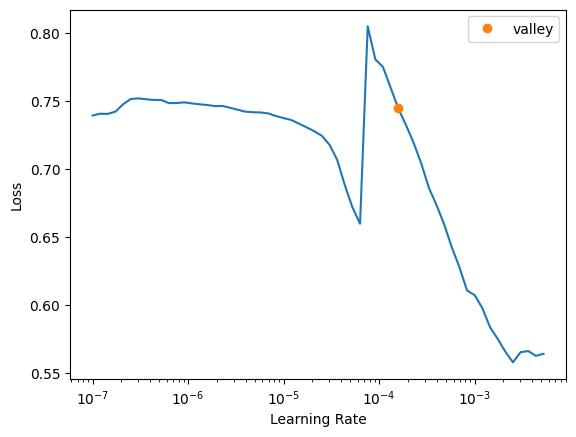

In [ ]:
learn_GELU = create_and_train_learner(dls16, fname='best_frozen_GELU', act_cls=torch.nn.GELU)

In [ ]:
learn_GELU = learn_GELU.load("best_frozen_GELU")
print("in-sample performance: {}".format(np.array(learn_GELU.validate(ds_idx=0)[1])))

in-sample performance: 0.8462976656427047


In [ ]:
print("out-of-sample performance: {}".format(np.array(learn_GELU.validate(ds_idx=1)[1])))

out-of-sample performance: 0.5429130910556932
